In [1]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pprint import pprint

In [2]:
torch.__version__

'2.4.0'

In [3]:
device = torch.device("cuda")
device

device(type='cuda')

In [4]:
text = open("/kaggle/input/war-and-peace/war_and_peace.txt", mode='r')
lines = text.readlines()
words = pd.Series(lines)
words 

0        "Well, Prince, so Genoa and Lucca are now just...
1        Buonapartes. But I warn you, if you don't tell...
2        if you still try to defend the infamies and ho...
3        Antichrist--I really believe he is Antichrist-...
4        to do with you and you are no longer my friend...
                               ...                        
20376    on the steps in the "reception room"--as Denis...
20377    hut--and it was then so warm that the officers...
20378    always some with Denisov and Rostov, sat in th...
20379                                                   \n
20380                        In April, Rostov was on order
Length: 20381, dtype: object

In [5]:
words = words.str.lower()
words = words.str.strip()
words = words.str.replace("\n", "")
words = words.str.replace('"', '')
words = words.str.replace(',', '')
words = words.str.replace('.', '')
words = words.str.replace('!', '')
words = words.str.replace("'", "")
words = words.str.replace("-", "")
words = words.str.replace("?", "")
words = words.str.replace("(", "")
words = words.str.replace(")", "")
words = words.str.replace(";", "")
words = words.str.replace(":", "")
words = words.str.strip()

In [6]:
words = words.sample(frac=1).reset_index(drop=True)
words = words.tolist()

In [7]:
words[:10]

['parting from his father and his wife he remembered the days when he',
 'from general field marshal kutuzov he asked i hope it is good news',
 'laughter provoked by a swarthy hussar officer who walked beside him',
 'empty the roads impassable the orthodox begin looting and in a way of',
 'monument from moscow which he intended to erect in his own garden to his',
 'mother keep you in their holy and allpowerful care',
 '',
 'bourienne with a radiant face that said i know nothing i am the same',
 'frightened and ashamed to have accepted charity in a house where such',
 'me satisfaction']

In [8]:
chars = sorted(list(set((" ".join(words)).split(" "))))
stoi = {s:i+2 for i,s in enumerate(chars)}
stoi['.'] = 1
stoi['<S>'] = 0
itos = {i:s for s,i in stoi.items()}
print(len(itos))

11189


In [9]:
block_size = 8 # context length: how many words/characters do we take to predict the next one?
X, Y = [], []
for w in words[:]:
  
  # print(w)
  context = [0] * block_size
  for ch in (w.split(" ") + ['<S>']):
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    # print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
# Move data to GPU

X = torch.tensor(X).to(device)
Y = torch.tensor(Y).to(device)

In [10]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([204978, 8]), torch.int64, torch.Size([204978]), torch.int64)

In [11]:
emb_dim = 32
emb = torch.nn.Embedding(len(stoi), emb_dim)
emb.weight

Parameter containing:
tensor([[-0.7839, -1.1590,  1.4539,  ..., -0.3440,  0.9214,  0.0887],
        [ 0.9028, -1.0789, -0.6572,  ..., -0.2432, -0.7650, -0.8508],
        [ 0.3716, -0.6606,  0.0727,  ..., -0.7902,  0.5068,  0.1076],
        ...,
        [-0.4554, -1.6937, -0.1517,  ..., -0.8275, -0.0541, -0.4286],
        [ 2.3782, -0.3504,  0.7010,  ..., -0.5253, -1.5178,  1.2393],
        [ 0.7920,  2.2044, -0.3482,  ..., -0.7603,  0.5658,  0.5038]],
       requires_grad=True)

In [12]:
class NextChar(nn.Module):
    def __init__(self, block_size, vocab_size, emb_dim, hidden_size):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.lin1 = nn.Linear(block_size*emb_dim, hidden_size)
        self.lin2 = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.emb(x)
        x = x.view(x.shape[0], -1)
        x = nn.functional.relu(self.lin1(x))
        x = self.lin2(x)
        return x 

In [13]:
import torch._dynamo
torch._dynamo.config.suppress_errors = True

model = NextChar(block_size, len(stoi), emb_dim, 1024).to(device)
model = torch.compile(model)

g = torch.Generator()
g.manual_seed(4000002)
def generate_words(model, itos, stoi, block_size, max_len=100):
    context = [0] * block_size
    name = ''
    for i in range(max_len):
        x = torch.tensor(context).view(1, -1).to(device)
        y_pred = model(x)
        ix = torch.distributions.categorical.Categorical(logits=y_pred).sample().item()
        # print(ix)
        ch = itos[ix]
        if ch == '<S>':
            break
        if ch not in ['"', ',', '.', '!', "'", "-", "?", "(", ")", ";", ":"]:
            name += ' '+ ch
        else:
            name += ch
        context = context[1:] + [ix]
    return name

for i in range(10):
    print(generate_words(model, itos, stoi, block_size))

W1026 13:40:39.003000 137698834884416 torch/_dynamo/convert_frame.py:1009] WON'T CONVERT forward /tmp/ipykernel_31/1837562056.py line 8 
W1026 13:40:39.003000 137698834884416 torch/_dynamo/convert_frame.py:1009] due to: 
W1026 13:40:39.003000 137698834884416 torch/_dynamo/convert_frame.py:1009] Traceback (most recent call last):
W1026 13:40:39.003000 137698834884416 torch/_dynamo/convert_frame.py:1009]   File "/opt/conda/lib/python3.10/site-packages/torch/_dynamo/convert_frame.py", line 948, in __call__
W1026 13:40:39.003000 137698834884416 torch/_dynamo/convert_frame.py:1009]     result = self._inner_convert(
W1026 13:40:39.003000 137698834884416 torch/_dynamo/convert_frame.py:1009]   File "/opt/conda/lib/python3.10/site-packages/torch/_dynamo/convert_frame.py", line 472, in __call__
W1026 13:40:39.003000 137698834884416 torch/_dynamo/convert_frame.py:1009]     return _compile(
W1026 13:40:39.003000 137698834884416 torch/_dynamo/convert_frame.py:1009]   File "/opt/conda/lib/python3.10

 recalls bespattered champagne saidmet example mentioned tenor moved studied our threaten thieves mad stillness dyou caper fences shavings creek brilliant sleigh rescue victoire downwards bade goldbach recounting standing evacuate sorrows prevented acted pelageya snowcovered semicircular it 15000 rentes lightas sipping teasing prearranged trophy ras advocates freshly outbuildings brings stuffy thronged obstinacy consequence wise roomthe wonder tengun glamour mercilessly intimacy ended provisioning bath christianity voices pondering voyez convince stairs shiftiness selfpreservation execution met deeds toilet order lolling savagely talentoh squeeze harms continually sprouted metallic clutch splashed assisted fortnights affairs em stopping vodkaget flares joyful pipes condescending brandishing permits ribbon kitty damaged
 knowledge even laughingstock liar ce needed gentlemeni meditatively affairyes campo shirts bayonets incident establish religious feu unflinching o clubs awards devilish

In [14]:
for param_name, param in model.named_parameters():
    print(param_name, param.shape)

len(stoi)

_orig_mod.emb.weight torch.Size([11189, 32])
_orig_mod.lin1.weight torch.Size([1024, 256])
_orig_mod.lin1.bias torch.Size([1024])
_orig_mod.lin2.weight torch.Size([11189, 1024])
_orig_mod.lin2.bias torch.Size([11189])


11189

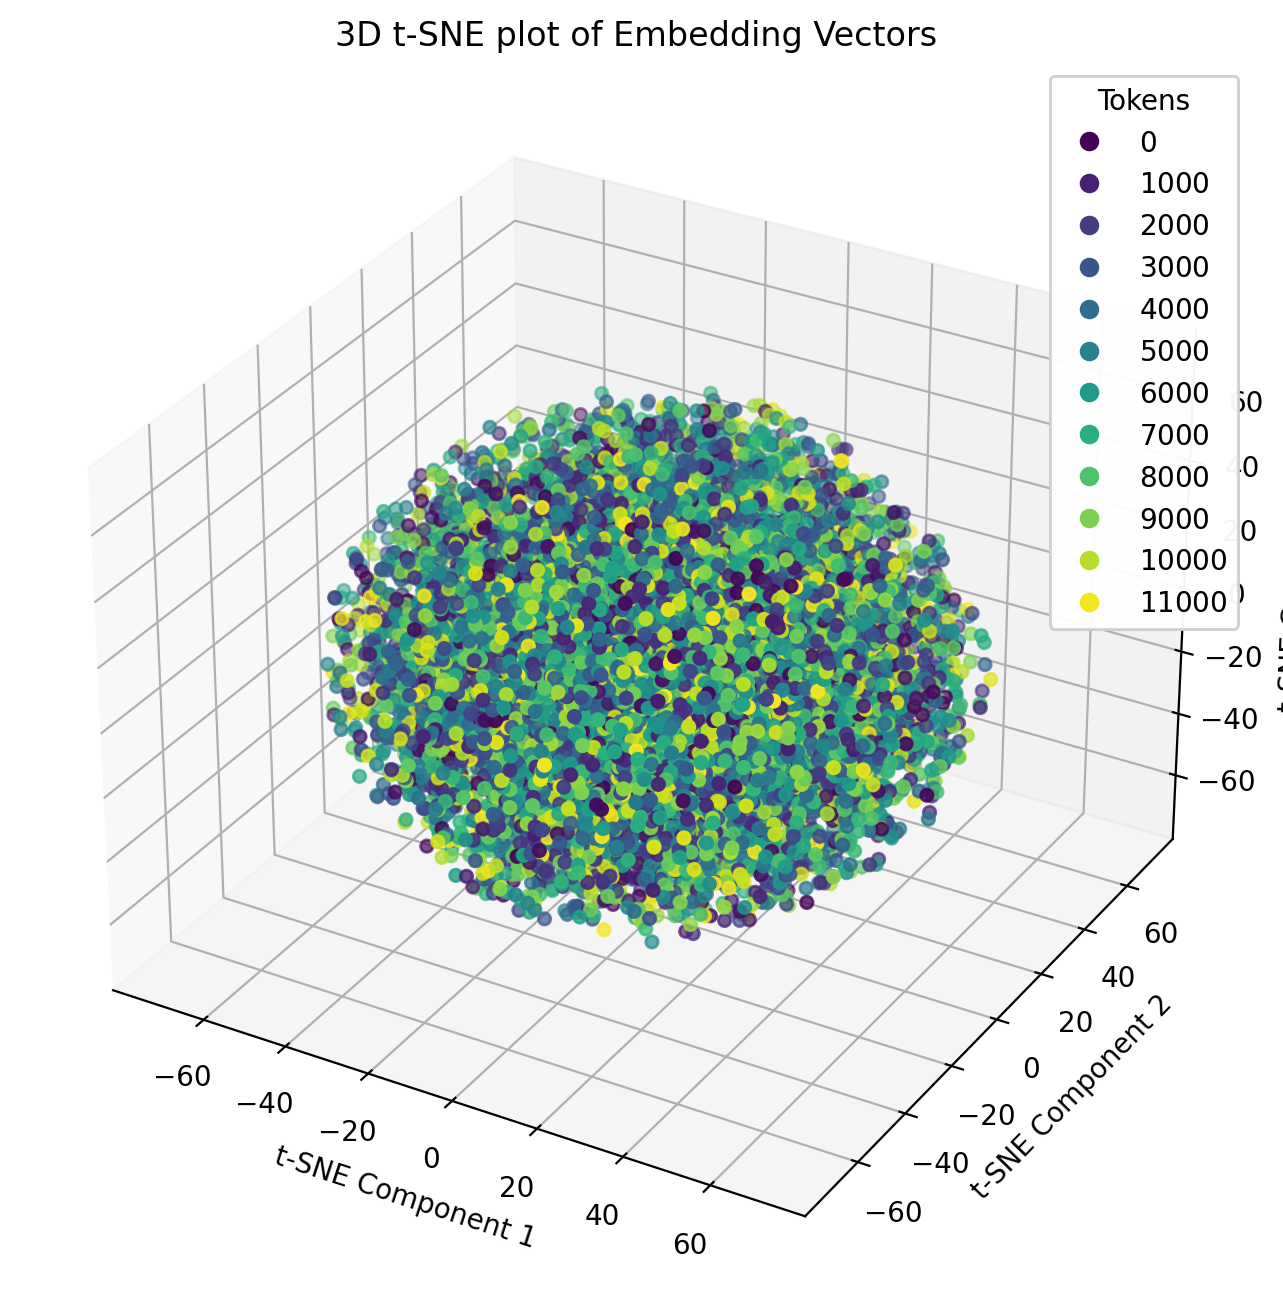

In [15]:
import torch
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting toolkit

# Get the embeddings (weights of the embedding layer)
emb_curr = model.emb
embeddings = emb_curr.weight.detach().cpu().numpy()

# Perform PCA to reduce to 20 dimensions
pca = PCA(n_components=20, random_state=42)
embeddings_pca = pca.fit_transform(embeddings)

# Perform t-SNE on the PCA-reduced embeddings with 3 components
tsne = TSNE(n_components=3, random_state=42)
X_embedded = tsne.fit_transform(embeddings_pca)

# Get the token names (keys from stoi) in the same order as embeddings
tokens = list(stoi.keys())

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')  # Create a 3D subplot

scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], 
                     c=np.arange(len(tokens)), cmap='viridis', marker='o')

# Create legend labels based on tokens
legend1 = ax.legend(*scatter.legend_elements(), title="Tokens")
ax.add_artist(legend1)

# Add title and labels for each axis
ax.set_title('3D t-SNE plot of Embedding Vectors')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')

plt.show()

In [16]:
import time
l1_lambda = 0.000007  # Regularization strength for L1 norm

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters(), lr=0.00007)

# Mini-batch training
batch_size = 4000
print_every = 10
elapsed_time = []

for epoch in range(1000):
    start_time = time.time()
    
    for i in range(0, X.shape[0], batch_size):
        x = X[i:i+batch_size]
        y = Y[i:i+batch_size]
        
        try:
            if x.shape[0] != 0:
                # Forward pass
                y_pred = model(x)
                loss = loss_fn(y_pred, y)
                loss = loss.to(device)

                # Compute L1 norm (sum of absolute values of weights)
                l1_norm = sum(torch.sum(torch.abs(param)) for param in model.parameters())

                # Add L1 regularization to the loss
                loss += l1_lambda * l1_norm

                # Backward pass
#                 print(y_pred)
#                 print(y)
                loss.backward()
                opt.step()
                opt.zero_grad()
        except:
            pass

    end_time = time.time()
    elapsed_time.append(end_time - start_time)
    try:
        if epoch % print_every == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
    except:
        pass

Epoch 0, Loss: 11.270565032958984
Epoch 10, Loss: 8.269089698791504
Epoch 20, Loss: 7.4696831703186035
Epoch 30, Loss: 6.822602272033691
Epoch 40, Loss: 6.246567726135254
Epoch 50, Loss: 5.713923454284668
Epoch 60, Loss: 5.230842590332031
Epoch 70, Loss: 4.83784294128418
Epoch 80, Loss: 4.552011013031006
Epoch 90, Loss: 4.343235969543457
Epoch 100, Loss: 4.182025909423828
Epoch 110, Loss: 4.051474094390869
Epoch 120, Loss: 3.942051887512207
Epoch 130, Loss: 3.847282886505127
Epoch 140, Loss: 3.763093948364258
Epoch 150, Loss: 3.686582088470459
Epoch 160, Loss: 3.6157588958740234
Epoch 170, Loss: 3.549042224884033
Epoch 180, Loss: 3.4853639602661133
Epoch 190, Loss: 3.423875331878662
Epoch 200, Loss: 3.364084482192993
Epoch 210, Loss: 3.306215763092041
Epoch 220, Loss: 3.2500784397125244
Epoch 230, Loss: 3.196319103240967
Epoch 240, Loss: 3.1449427604675293
Epoch 250, Loss: 3.096036434173584
Epoch 260, Loss: 3.04935884475708
Epoch 270, Loss: 3.0048069953918457
Epoch 280, Loss: 2.9623465

In [17]:
for i in range(10):
    print(generate_words(model, itos, stoi, block_size))

 
 amid irregular of the line was heard of all the
 
 and always having at the rats of his bed at which will be quiet day on the
 with his dying princess
 are the counts object came on the blue of the wag which
 appreciate by vexation well as a matter would you can
 he released a little to man with kutuzov
 
 forgiveness me do you know my dear i


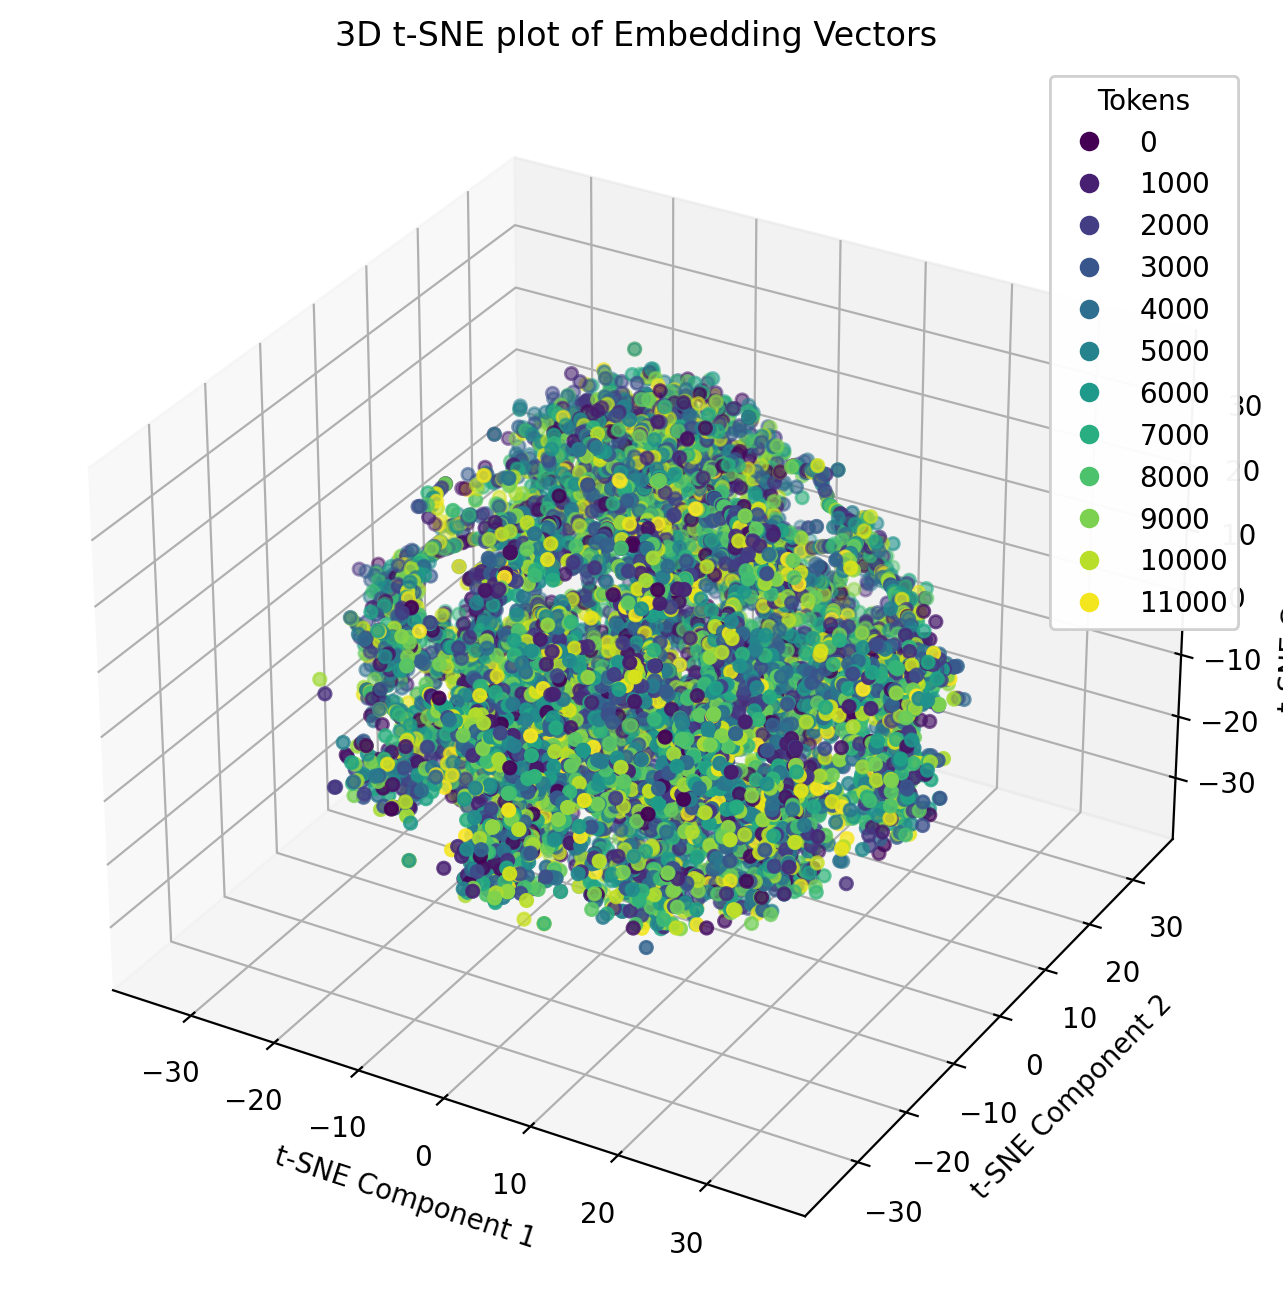

In [18]:
emb_curr = model.emb
embeddings = emb_curr.weight.detach().cpu().numpy()

# Perform PCA to reduce to 20 dimensions
pca = PCA(n_components=20, random_state=42)
embeddings_pca = pca.fit_transform(embeddings)

# Perform t-SNE on the PCA-reduced embeddings with 3 components
tsne = TSNE(n_components=3, random_state=42)
X_embedded = tsne.fit_transform(embeddings_pca)

# Get the token names (keys from stoi) in the same order as embeddings
tokens = list(stoi.keys())

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')  # Create a 3D subplot

scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], 
                     c=np.arange(len(tokens)), cmap='viridis', marker='o')

# Create legend labels based on tokens
legend1 = ax.legend(*scatter.legend_elements(), title="Tokens")
ax.add_artist(legend1)

# Add title and labels for each axis
ax.set_title('3D t-SNE plot of Embedding Vectors')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')

plt.show()


In [19]:
model_cpu = model.cpu()

torch.save(model_cpu.state_dict(), "model_8_64_1024.pth")

In [20]:
model = model.to(device)